In [1]:
# Notebooks: https://github.com/lavinigam-gcp/io24-gemini-api

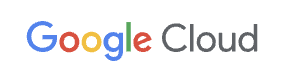 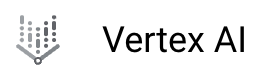

# **Demo 3/3**: Gemini API in Vertex AI (Production-ready)



## Overview

🧡 There are two levels of API platforms for Gemini API:

- **Gemini API in Google AI for Developers**: Experiment, prototype, and deploy small projects.

- 👏 **Gemini API in Vertex AI**: Build enterprise-ready projects in Google Cloud Vertex AI

This notebook uses the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/start/quickstarts/quickstart-multimodal) to develop a production-ready generative AI solution.

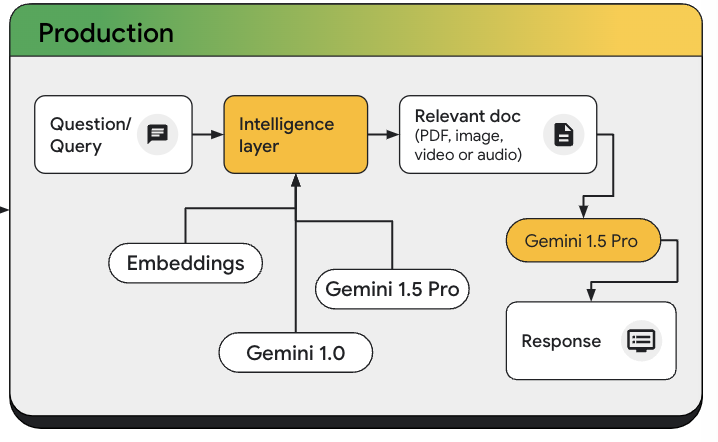

### **What do we want to build?**

#### 1. Able to ask a question without the need to supply the source files

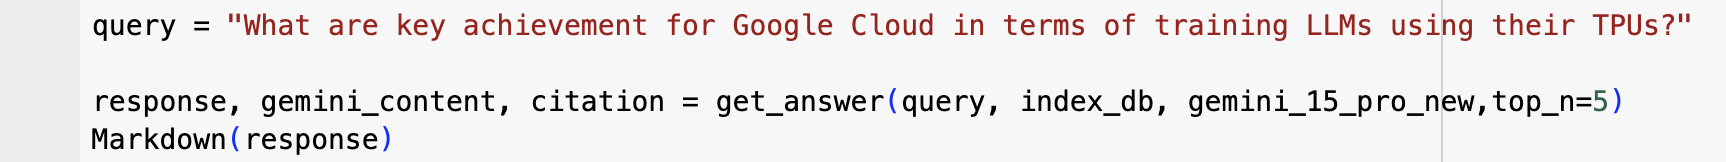

#### 2. Able to get the answer

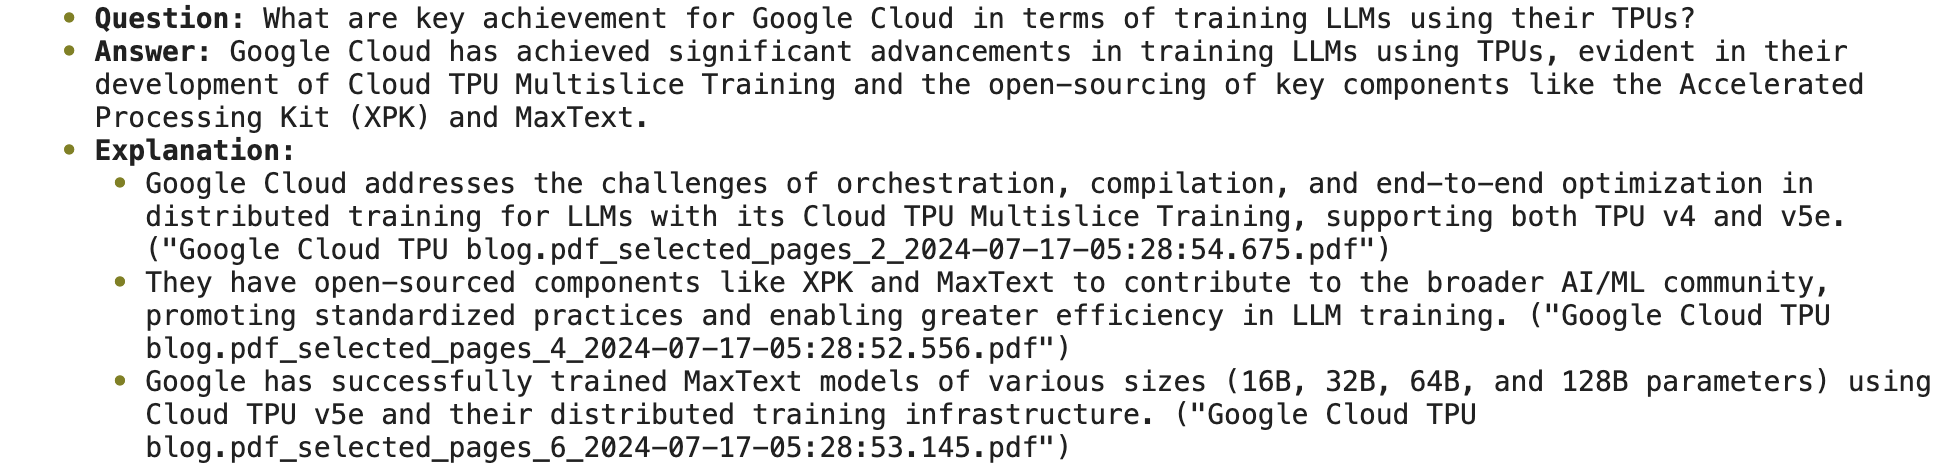

#### 3. Able to obtain the citation of the source files

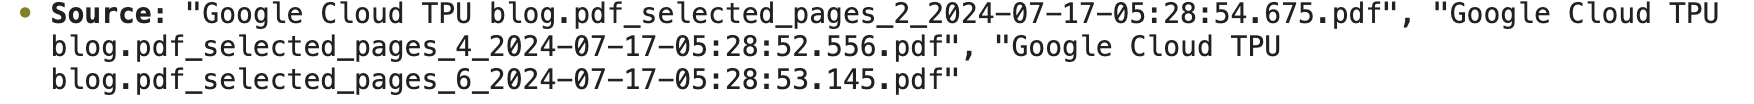

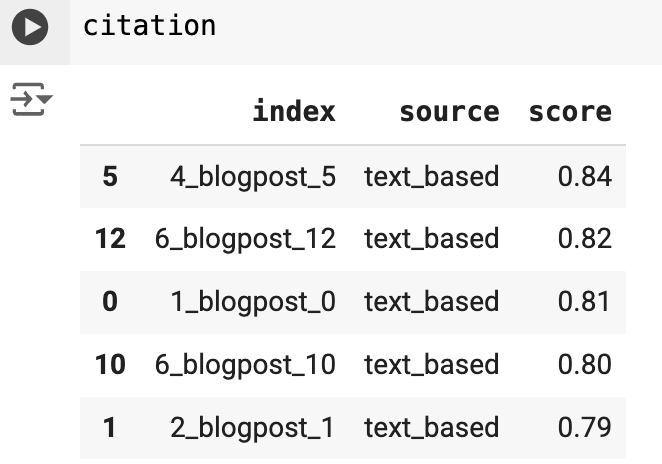

## Get started

### Install Google Cloud AI Platform SDK and other required packages


In [ ]:
%%capture

! pip install --upgrade google-cloud-aiplatform
! pip install PyPDF2

### Authentication


In [ ]:
import vertexai
from google.colab import auth
from google.cloud import storage


# Authenticate Colab user to Google Cloud
auth.authenticate_user()

# Define Google Cloud project information
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "" # @param {type:"string"}


# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Initialize cloud storage
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(BUCKET_NAME)

### Import libraries

In [ ]:
import IPython
from IPython.display import display, Markdown, Latex
import vertexai.generative_models as genai
import PyPDF2
import pandas as pd
import time
from vertexai.generative_models import (
    GenerativeModel,
    Part,
    GenerationConfig,
    HarmCategory,
    HarmBlockThreshold,
)
import PyPDF2
from io import BytesIO
from vertexai.preview.generative_models import Part
from google.cloud import storage
from io import BytesIO
from datetime import datetime, timezone
import numpy as np
import numpy as np
from typing import List
from IPython.display import display, Markdown, Latex
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from vertexai.generative_models import (
    GenerativeModel,
    Part,
    GenerationConfig,
    HarmCategory,
    HarmBlockThreshold,
)
from typing import List
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from google.cloud import storage
from io import BytesIO
from rich import print as rich_print
from rich.markdown import Markdown as rich_Markdown
import pickle
pd.options.mode.chained_assignment = None

## Building Metadata & Index

In [ ]:
gemini_15_pro_new = genai.GenerativeModel("gemini-1.5-pro-001")
gemini_15_flash = genai.GenerativeModel("gemini-1.5-flash-001")

In [ ]:
#@title Helper Functions

def get_gemini_response(model, generation_config=None,
                        safety_settings=None,
                        uri_path=None,mime_type=None, prompt=None):
  if not generation_config:
    generation_config = {
      "max_output_tokens": 8192,
      "temperature": 1,
      "top_p": 0.95,
    }

  if not safety_settings:
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

  uri = "gs://"+uri_path
  file = genai.Part.from_uri(
    mime_type=mime_type,
    uri=uri
    )
  responses = model.generate_content([file, prompt],
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )
  final_response = []
  for response in responses:
    try:
      final_response.append(response.text)
    except ValueError:
      # print("Something is blocked...")
      final_response.append("blocked")

  return "".join(final_response)

def get_text_from_pdf(bucket):
  extracted_text = []
  # Iterate over all blobs (files) in the bucket
  for blob in bucket.list_blobs():
      if blob.name.startswith("production/"):
        if blob.name.lower().endswith('.pdf'):  # Check if the file is a PDF
            # Download the PDF to a BytesIO object
            pdf_content = BytesIO(blob.download_as_bytes())
            try:
                # Process the PDF using PyPDF2
                pdf_reader = PyPDF2.PdfReader(pdf_content)
                text = ""
                pdf_data = []
                text_type = "/".join(blob.name.split("/")[1:-1])
                filename = blob.name.split("/")[-1]
                for page_num in range(len(pdf_reader.pages)):
                    page = pdf_reader.pages[page_num]
                    text = page.extract_text()
                    if text:
                      pdf_data.append(
                      {
                          'text_type' : text_type,
                          'gcs_path': "gs://"+blob.bucket.name+"/"+blob.name,
                          'page_number': page_num+1,
                          'text': text
                      }
                      )
                extracted_text.extend(pdf_data)
                # break
            except:
                print(f"Warning: Could not read PDF file '{blob.name}' (might be encrypted or corrupted)")
  return pd.DataFrame(extracted_text)

# 16-17 min
def get_text_from_video(bucket, model, prompt, time_sleep=5):
  video_metadata = []
  for blob in bucket.list_blobs():
      if blob.name.startswith("production/"):
        if blob.name.lower().endswith('.mp4'):
          print("processing....",blob.name)
          video_type = "/".join(blob.name.split("/")[1:-1])
          gcs_path = "/".join(blob.id.split("/")[:-1])
          try:
            video_description = get_gemini_response(uri_path=gcs_path,
                                                    model=model,
                                                    mime_type='video/mp4',
                                                    prompt = prompt)
            if video_description:
              video_metadata.append(
                  {
                      'video_gcs': "gs://"+blob.bucket.name+"/"+blob.name,
                      'video_type':video_type,
                      'video_description': video_description
                  }

              )
          except:
            print("Something Failed........")
            video_metadata.append(
                  {
                      'video_gcs': "gs://"+blob.name,
                      'video_type':video_type,
                      'video_description': ""
                  }

              )
          # print("sleeping......")
          time.sleep(time_sleep)
          # break
  return pd.DataFrame(video_metadata)

# ~20 min
def get_text_from_audio(bucket, model, prompt, time_sleep=5):
  # Iterate over all blobs (files) in the bucket
  audio_metadata = []
  for blob in bucket.list_blobs():
    if blob.name.startswith("production/"):
      if blob.name.lower().endswith('.mp3'):
        print("processing....",blob.name)
        video_type = "/".join(blob.name.split("/")[1:-1])
        gcs_path = "/".join(blob.id.split("/")[:-1])
        # print(gcs_path)
        try:
          audio_description = get_gemini_response(uri_path=gcs_path,
                                                  model=model,
                                                  mime_type='audio/mpeg',
                                                  prompt=prompt)
          if audio_description:
            audio_metadata.append(
                {
                    'audio_gcs': "gs://"+blob.bucket.name+"/"+blob.name,
                    'audio_type':video_type,
                    'audio_description': audio_description
                }

            )
        except:
          print("Something Failed........")
          audio_metadata.append(
              {
                  'audio_gcs': blob.name,
                  'audio_type':video_type,
                  'audio_description': ""
              }

          )
        # print("sleeping......")
        time.sleep(time_sleep)
        # break
  return pd.DataFrame(audio_metadata)

def split_text_into_chunks(df, text_column, chunk_size):
    """Splits text into chunks of specified size, preserving other column values."""

    # Create a list of new dataframes, one for each chunk
    new_dfs = []
    for _, row in df.iterrows():
        text_chunks = [row[text_column][i:i + chunk_size] for i in range(0, len(row[text_column]), chunk_size)]
        for chunk in text_chunks:
            new_row = row.copy()  # Copy all other columns
            new_row[text_column] = chunk
            new_dfs.append(pd.DataFrame([new_row]))

    return pd.concat(new_dfs, ignore_index=True)  # Combine into single dataframe

def get_text_embeddings(
    texts: List[str] = ["banana muffins? ", "banana bread? banana muffins?"],
    task: str = "RETRIEVAL_DOCUMENT",
    model_name: str = "textembedding-gecko@003",
) -> List[List[float]]:
    # print("doing...")
    """Embeds texts with a pre-trained, foundational model."""
    model = TextEmbeddingModel.from_pretrained(model_name)
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    embeddings = model.get_embeddings(inputs)
    return [embedding.values for embedding in embeddings][0]

def backup_metadata_in_pickle(extracted_text,
                              video_metadata,
                              audio_metadata,
                              index_db,
                              output_path_with_name):
  import pickle
  data_to_save = {
      "extracted_text": extracted_text,
      "video_metadata": video_metadata,
      "audio_metadata": audio_metadata,
      "index_db": index_db
  }
  print("Backing up the metadata in: ",output_path_with_name+".pkl")
  with open(f"{output_path_with_name}.pkl", "wb") as f:
      pickle.dump(data_to_save,f)

# def load_backuped_metadata(backup_path_with_name):
#   import pickle
#   import pandas as pd

#   with open(f"{backup_path_with_name}.pkl", "rb") as f:
#       loaded_data = pickle.load(f)

#   extracted_text = loaded_data["extracted_text"]
#   video_metadata = loaded_data["video_metadata"]
#   audio_metadata = loaded_data["audio_metadata"]
#   index_db = loaded_data["index_db"]
#   return extracted_text, video_metadata, audio_metadata, index_db

def load_backuped_metadata(bucket):
    for blob in bucket.list_blobs():
      if blob.name.startswith("asset/"):
        if blob.name.lower().endswith('.pkl'):
          with blob.open("rb") as f:
            loaded_data = pickle.load(f)

    extracted_text = loaded_data["extracted_text"]
    video_metadata = loaded_data["video_metadata"]
    audio_metadata = loaded_data["audio_metadata"]
    index_db = loaded_data["index_db"]

    return extracted_text, video_metadata, audio_metadata, index_db


## Step 1 - Text Extraction

### From all reports

![](https://storage.googleapis.com/gemini-lavi-asset/img/Step1.png)

In [ ]:
%%time
extracted_text = get_text_from_pdf(bucket)

CPU times: user 2min 10s, sys: 698 ms, total: 2min 10s
Wall time: 2min 23s


In [ ]:
extracted_text.head()

,text_type,gcs_path,page_number,text
0,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,1,Google\nCloud\ndemonstrates\nthe\nworld’ s\nla...
1,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,2,Source:\n“Computation\nused\nto\ntrain\nnotabl...
2,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,3,1.\nOrchestration:\nThe\nsoftware\nstack\nthat...
3,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,4,Cloud\nTPU\nMultislice\nTraining\nhas\nthe\nfo...
4,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,5,1.\nRobust\norchestration\nand\nscalability:\n...


In [ ]:
print("Pages per file...",
      extracted_text['gcs_path'].value_counts())

Pages per file... gcs_path
gs://gemini-lavi-asset/production/reports/2021/annual_report/2021-alphabet-annual-report.pdf         136
gs://gemini-lavi-asset/production/reports/2020/annual_report/2020-alphabet-annual-report.pdf         132
gs://gemini-lavi-asset/production/reports/2022/annual_report/2022-alphabet-annual-report.pdf         129
gs://gemini-lavi-asset/production/reports/2020/quaterly_report/20210203-alphabet-10k.pdf             100
gs://gemini-lavi-asset/production/reports/2023/quaterly_report/goog-10-k-2023.pdf                     97
gs://gemini-lavi-asset/production/reports/2021/quaterly_report/20220202-alphabet-10k.pdf              95
gs://gemini-lavi-asset/production/reports/2022/quaterly_report/goog-10-k-q4-2022.pdf                  92
gs://gemini-lavi-asset/production/reports/2020/quaterly_report/20201030-alphabet-10q.pdf              73
gs://gemini-lavi-asset/production/reports/2020/quaterly_report/20200731-alphabet-10q.pdf              70
gs://gemini-lavi-asset/produ

In [ ]:
print("total files: ....",
      len(extracted_text['gcs_path'].value_counts().index))

total files: .... 32


In [ ]:
print("total pages: ....",
      sum(extracted_text['gcs_path'].value_counts().values))

total pages: .... 1648


In [ ]:
rich_Markdown(extracted_text['text'][9])

Storage Interacting with persistent storage is a crucial aspect of training. Our 199-pod cluster had 1 Tb/s to     
Cloud Storage, 1,270 Tb/s inter-slice DCN, and 73,400 Tb/s intra-slice ICI. When loading Docker images, loading    
data, and reading/writing checkpoints, we optimized the interaction with persistent storage. We found that at large
scale, data loading from Cloud Storage began to affect performance, starting at 64 pods scale. We have since       
mitigated this limit with a distributed data loading strategy that alleviates pressure on Cloud Storage by having a
subset of hosts load data. We also found limits due to checkpointing. By default, checkpointing loads the full     
checkpoint into each data parallel replica from Cloud Storage. Consider checkpoint loading for a 128B model sharded
with cross-pod data parallelism. For a traditional optimizer state of three numbers per parameter (4bytes/number), 
this means loading a checkpoint of size ~1.536 TB separately into each pod (in this case for 199 pods). This would 
require 199 pods * 1.536TB/pod, or approximately 300TB of bandwidth. For reasonable performance from persistent    
storage of 1 Tb/s, this would require approximately 2,400 seconds (40 minutes). However, we needed much lower start
or restart time, so had to take a different approach.

### From audio files

![](https://storage.googleapis.com/gemini-lavi-asset/img/Step1-Audio.png)

In [ ]:
%%time

audio_description_extraction_prompt = """Transcribe and analyze the audio, identifying key topic shifts or changes in focus. Divide the audio into segments based on these transitions.
For each segment:
* **Summarize:** Briefly describe the main topic or theme of the segment.
* **Contextualize:** Explain how this topic fits into the broader conversation or narrative.
* **Analyze:** Explore the significance of this topic, the perspectives presented, and any potential biases or underlying assumptions.
* **Synthesize:** Connect this topic to other themes or ideas mentioned in the audio, highlighting relationships and overarching patterns.
Conclude with a thematic analysis of the entire audio. Identify the most prominent themes, how they are interconnected, and the overall message or purpose of the audio.
"""

In [ ]:
%%time
audio_metadata_flash = get_text_from_audio(bucket, gemini_15_flash,
                                     audio_description_extraction_prompt,
                                    )

processing.... production/earning_calls/2023 Annual Meeting of Stockholders.mp3
processing.... production/earning_calls/Alphabet 2023 Q1 Earnings Call.mp3
processing.... production/earning_calls/Alphabet 2023 Q2 Earnings Call.mp3
processing.... production/earning_calls/Alphabet 2023 Q3 Earnings Call.mp3
processing.... production/earning_calls/Alphabet 2023 Q4 Earnings Call.mp3
processing.... production/podcast/dialogue_dispatch/Can AI help us accelerate a green economy_ _ Dialogues Dispatch Podcast _ Ep 5 Trailer.mp3
processing.... production/podcast/dialogue_dispatch/Can AI help us accelerate a green economy_ _ Dialogues Dispatch Podcast _ Episode 5.mp3
processing.... production/podcast/dialogue_dispatch/Dialogues Dispatch Podcast _ Series Trailer.mp3
processing.... production/podcast/dialogue_dispatch/How can AI help accelerate progress on the UN SDGs_ _ Dialogues Dispatch Podcast _ Ep 6 Trailer.mp3
processing.... production/podcast/dialogue_dispatch/How can AI help accelerate progre

In [ ]:
audio_metadata_flash.tail()

,audio_gcs,audio_type,audio_description
13,gs://gemini-lavi-asset/production/podcast/dial...,podcast/dialogue_dispatch,## Dialogue Dispatch: AI as a Game Changer in ...
14,gs://gemini-lavi-asset/production/podcast/dial...,podcast/dialogue_dispatch,## Segment 1: Introduction and AI Governance\n...
15,gs://gemini-lavi-asset/production/podcast/dial...,podcast/dialogue_dispatch,## Dialogues Dispatch: AI and Governance \n\n...
16,gs://gemini-lavi-asset/production/podcast/dial...,podcast/dialogue_dispatch,## Dialogues Dispatch: Generative AI and the F...
17,gs://gemini-lavi-asset/production/podcast/dial...,podcast/dialogue_dispatch,## Transcript and Analysis of Dialogues Dispat...


In [ ]:
print("total files: ....",
      len(audio_metadata_flash['audio_gcs'].value_counts().index))

total files: .... 18


In [ ]:
rich_Markdown(audio_metadata_flash['audio_description'][2])

Alphabet's Second Quarter 2023 Earnings Call: A Thematic Analysis                         

This audio transcript captures Alphabet's second quarter 2023 earnings conference call. It showcases the company's 
strategic focus on AI innovation, its robust financial performance, and the growing role of technology in various  
sectors. The call is divided into distinct segments marked by shifts in topic:                                     

Segment 1: Introduction and AI Focus (0:00-4:15)                                                                   

 • Summarize: The speaker begins with introductory remarks, outlining the call's purpose and participants. The main
   focus quickly shifts to Alphabet's progress in AI, highlighting its strategic importance and four key areas of  
   application: knowledge & learning, creativity & productivity, innovation enablement, and responsible            
   development.                                                                                                    
 • Contextualize:  This segment sets the stage for the conversation by introducing Alphabet's commitment to AI and 
   its vision for its widespread impact.                                                                           
 • Analyze: Alphabet emphasizes its long-standing leadership in AI and its ability to leverage this expertise to   
   improve core products like search. The company outlines its initiatives in making AI accessible and responsible,
   showcasing a forward-looking and proactive approach to this rapidly evolving field.                             
 • Synthesize: This segment lays the groundwork for the subsequent discussion on Alphabet's business segments and  
   financial performance, highlighting how AI is driving growth and innovation across the company.                 

Segment 2: Google Cloud and AI (4:15 - 8:20)                                                                       

 • Summarize: The speaker details the strong growth of Google Cloud, emphasizing its role as a leading platform for
   training and serving generative AI models. Examples of customer use cases are provided, demonstrating the       
   diverse applications of AI in different sectors.                                                                
 • Contextualize: This segment expands on the earlier discussion of AI, focusing on Google Cloud as a key driver of
   its expansion and customer acquisition.                                                                         
 • Analyze: Alphabet highlights its investment in AI infrastructure and its ability to serve a diverse range of AI 
   models, including third-party and open-source options. This showcases the company's commitment to both internal 
   innovation and collaboration with external partners, aiming to foster a broader AI ecosystem.                   
 • Synthesize:  This segment reinforces the connection between AI and Google Cloud, illustrating how the cloud     
   platform is becoming a central hub for developing and deploying AI solutions.                                   

Segment 3: YouTube and Shorts (8:20-12:00)                                                                         

 • Summarize: The speaker focuses on YouTube's audience growth and engagement, particularly highlighting the       
   success of Shorts and connected TV. The speaker also emphasizes the company's focus on supporting creators and  
   fostering a thriving content ecosystem.                                                                         
 • Contextualize: This segment transitions from the cloud to Alphabet's other major business area, YouTube.        
 • Analyze:  Alphabet emphasizes its multi-format content strategy, targeting audience growth across different     
   platforms and devices. The success of Shorts and connected TV is presented as a testament to the company's      
   ability to adapt to changing user preferences and create engaging conte

### From video files

![](https://storage.googleapis.com/gemini-lavi-asset/img/Step1_Video.png)

In [ ]:
%%time

video_description_extraction_prompt = """Transcribe and analyze the video, intelligently segmenting it based on shifts in topic, focus, or narrative progression.
For each identified segment:
**Concise Summary**: Distill the core theme or message in 1-2 sentences.
**Thematic Context**: How does this segment contribute to the overarching narrative or argument?
**Critical Analysis**: Delve into the segment's implications, perspectives presented, and potential biases.
**Connections**: Link this segment to other parts of the video, revealing patterns and relationships.

Conclude by synthesizing the video's main themes, their interconnections, and the overarching purpose or message.
"""


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [ ]:
%%time

video_metadata_flash = get_text_from_video(bucket,gemini_15_flash,
                                    video_description_extraction_prompt,
                                    )

processing.... production/product_launch/gemini/Can AI understand your outfit  Testing Gemini.mp4
processing.... production/product_launch/gemini/Can_AI_understand_new_emojis_Testing_Gemini.mp4
processing.... production/product_launch/gemini/Converting images into code with AI  Testing Gemini.mp4
processing.... production/product_launch/gemini/Finding connections with AI  Testing Gemini.mp4
processing.... production/product_launch/gemini/Googles newest AI in 90 seconds  Gemini.mp4
processing.... production/product_launch/gemini/Googles newest and most capable AI  Gemini.mp4
processing.... production/product_launch/gemini/Guessing movies with AI  Testing Gemini.mp4
processing.... production/product_launch/gemini/Math & physics with AI  Gemini.mp4
processing.... production/product_launch/gemini/Multimodal prompting with a 44-minute movie  Gemini 15 Pro Demo.mp4
processing.... production/product_launch/gemini/Personalized AI for you  Gemini.mp4
processing.... production/product_launch/gem

In [ ]:
video_metadata_flash.head()

,video_gcs,video_type,video_description
0,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,## Video Analysis: Can Gemini Understand Outfi...
1,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,## Video Analysis: Can Gemini Understand Unus...
2,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,## Video Analysis: Can Gemini Turn Images into...
3,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,"## Video Analysis: ""Can Gemini find similariti..."
4,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,"## Video Analysis: ""Introducing Gemini""\n\n**S..."


In [ ]:
print("total files: ....",
      len(video_metadata_flash['video_gcs'].value_counts().index))

total files: .... 18


In [ ]:
rich_Markdown(video_metadata_flash['video_description'][0])

Video Analysis: Can Gemini Understand Outfits?                                   

Segment 1: 0:00-0:19                                                                                               

Concise Summary: The video poses the question: "Can Gemini understand outfits?"  It starts by testing Gemini with a
simple item, a blue puffer jacket.                                                                                 

Thematic Context: This segment introduces the core concept of the video – exploring Gemini's ability to interpret  
fashion and understand the context of clothing items.                                                              

Critical Analysis: The question highlights the potential of AI for understanding human concepts like fashion.      
However, it also raises questions about the depth of understanding AI can achieve.                                 

Connections: This segment sets up the rest of the video by establishing a question and a method of testing Gemini's
abilities.                                                                                                         

Segment 2: 0:20-0:31                                                                                               

Concise Summary: Gemini responds to the question about the blue puffer jacket by suggesting that someone wearing it
is dressed for intergalactic travel, demonstrating a connection between the jacket and the context of space travel.

Thematic Context: This segment showcases Gemini's ability to link visual cues (the jacket) to a broader concept    
(space travel) and even add humor with the addition of a saxophone.                                                

Critical Analysis: Gemini's response suggests a level of understanding of fashion and its connection to activities 
and contexts. It also hints at AI's potential to generate creative and humorous interpretations.                   

Connections: This segment builds upon the previous segment by providing Gemini's first response and showcasing its 
ability to  interpret clothing items in a more nuanced way.                                                        

Segment 3: 0:32-0:38                                                                                               

Concise Summary: The video further probes Gemini by asking it to "coin a term" for the style of the outfit (jacket 
and saxophone). Gemini responds with "Mooncore," demonstrating a sense of humor and understanding of current       
trends.                                                                                                            

Thematic Context: This segment continues to explore Gemini's ability to understand and analyze fashion trends,     
going beyond simple interpretation to suggesting new terminology.                                                  

Critical Analysis:  This segment highlights the potential of AI to engage in creative tasks like generating new    
terms and concepts related to fashion. It suggests that AI can participate in the evolution of cultural language.  

Connections: This segment reinforces the previous ones by showcasing Gemini's creative and humorous capabilities,  
demonstrating its ability to go beyond basic understanding and engage in more sophisticated tasks related to       
fashion.                                                                                                           

Segment 4: 0:39-0:44                                                                                               

Concise Summary: The video concludes with a screen displaying the Gemini logo and the phrase                       
"deepmind.google/gemini" along with additional questions related to Gemini's capabilities, leaving the audience to 
anticipate further explorations.                                                                                   

Thematic Context: This segment serves as a concluding statement and a ca

## Step 2 - Text Chunking

<img src="https://storage.googleapis.com/gemini-lavi-asset/img/Step2-Chunking.png" width="500" />

In [ ]:
# Step 2 [Why do we still do chunking? Explain ----
# 1) show the token count
# 2) reduce noise while search  ]
# latency and cost consideriation - you can still do that, but would it make sense
# Out of 5M token "information" -> you would still want to makes ure that the 1M that you send are the most relevant 1M
# Chunking the Text to smaller size to make precise match with queries

chunk_size =500
extracted_text_chunk_df = split_text_into_chunks(extracted_text, 'text', chunk_size)
video_metadata_chunk_df = split_text_into_chunks(video_metadata_flash, 'video_description', chunk_size)
audio_metadata_chunk_df = split_text_into_chunks(audio_metadata_flash, 'audio_description', chunk_size)

In [ ]:
extracted_text_chunk_df.head()

,text_type,gcs_path,page_number,text
0,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,1,Google\nCloud\ndemonstrates\nthe\nworld’ s\nla...
1,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,2,Source:\n“Computation\nused\nto\ntrain\nnotabl...
2,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,3,1.\nOrchestration:\nThe\nsoftware\nstack\nthat...
3,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,3,e\nscale\nrequires\ndeep\nexpertise\nthroughou...
4,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,3,"scalable,\nreliable,\nand\neasy-to-use\nfor\ne..."


In [ ]:
rich_Markdown(
    extracted_text[
        (extracted_text["page_number"] == 3)
        & (
            extracted_text["gcs_path"]
            == "gs://gemini-lavi-asset/production/blogpost/Google Cloud TPU blog.pdf"
        )
    ]["text"].values[0]
)


Orchestration: The software stack that is used for distributed training needs to manage all of these chips and     
scale as high as possible to accelerate training times. This stack also needs to be reliable, fault tolerant, and  
resilient in order to ensure training progress. 2. Compilation : As training progresses, the computation and       
communication that happen across the chips need to be managed effectively by a high-performance compiler. 3.       
End-to-end optimization : Distributed training at large scale requires deep expertise throughout both the ML       
training stack and the end-to-end ML training workflow, from storage and compute to memory and networking. Google  
Cloud TPU Multislice Training To address each of the above distributed training challenges across orchestration,   
compilation, and end-to-end optimization, today we announced the general availability of Cloud TPU Multislice      
Training. This full-stack training offering — supporting TPU v4 and v5e — is built from the ground up to be        
scalable, reliable, and easy-to-use for end-to-end optimization of ML training. With Multislice, you can leverage  
Google’s cost-efficient, versatile, and scalable Cloud TPUs for training ML models efficiently and at large scale.

In [ ]:
rich_Markdown(extracted_text_chunk_df.iloc[2]['text'])

Orchestration: The software stack that is used for distributed training needs to manage all of these chips and     
scale as high as possible to accelerate training times. This stack also needs to be reliable, fault tolerant, and  
resilient in order to ensure training progress. 2. Compilation : As training progresses, the computation and       
communication that happen across the chips need to be managed effectively by a high-performance compiler. 3.       
End-to-end optimization : Distributed training at larg

In [ ]:
rich_Markdown(extracted_text_chunk_df.iloc[3]['text'])

e scale requires deep expertise throughout both the ML training stack and the end-to-end ML training workflow, from
storage and compute to memory and networking. Google Cloud TPU Multislice Training To address each of the above    
distributed training challenges across orchestration, compilation, and end-to-end optimization, today we announced 
the general availability of Cloud TPU Multislice Training. This full-stack training offering — supporting TPU v4   
and v5e — is built from the ground up to be

In [ ]:
rich_Markdown(extracted_text_chunk_df.iloc[4]['text'])

scalable, reliable, and easy-to-use for end-to-end optimization of ML training. With Multislice, you can leverage  
Google’s cost-efficient, versatile, and scalable Cloud TPUs for training ML models efficiently and at large scale.

## Step 3 - Embedding



<img src="https://storage.googleapis.com/gemini-lavi-asset/img/Step2-Chunking_embedding.png" width="500" />

load the metadata, as this step would require lot of time and quota to run.

## Step 4 - Building Index

In [ ]:
# Step 4 Building final metadata and index for the vector db
# Building index

extracted_text_chunk_df['index'] = extracted_text_chunk_df['page_number'].astype(str)+ "_"+extracted_text_chunk_df['text_type']+ "_" + extracted_text_chunk_df.index.astype(str)
video_metadata_chunk_df['index'] = video_metadata_chunk_df['video_type']+ "_" + video_metadata_chunk_df.index.astype(str)
audio_metadata_chunk_df['index'] = audio_metadata_chunk_df['audio_type']+ "_" + audio_metadata_chunk_df.index.astype(str)

#Adding source to identify type of file
print("Adding source type in the metadata......")
extracted_text_chunk_df['source'] = "text_based"
video_metadata_chunk_df['source'] = "video_based"
audio_metadata_chunk_df['source'] = "audio_based"

#Building index data
print("Building index data from the metadata......")
index_db = pd.concat([extracted_text_chunk_df[['index','source','embeddings']],
          video_metadata_chunk_df[['index','source','embeddings']],
          audio_metadata_chunk_df[['index','source','embeddings']]
                      ],
        axis=0).reset_index(drop=True)

### Backing up the metadata

In [ ]:
# download documents and images used in this notebook - will take ~30 sec
!gsutil -m -q rsync -r gs://gemini-lavi-asset/asset/ .
print("Download completed")


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Download completed


In [ ]:
# extracted_text, video_metadata, audio_metadata, index_db = load_backuped_metadata("/content/metadata")
import pickle
extracted_text, video_metadata, audio_metadata, index_db = load_backuped_metadata(bucket)

In [ ]:
extracted_text.head()

,text_type,gcs_path,page_number,text,embeddings,index,source
0,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,1,Google\nCloud\ndemonstrates\nthe\nworld’ s\nla...,"[0.0026181433349847794, -0.006980935577303171,...",1_blogpost_0,text_based
1,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,2,Source:\n“Computation\nused\nto\ntrain\nnotabl...,"[0.02464565820991993, -0.020231368020176888, -...",2_blogpost_1,text_based
2,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,3,1.\nOrchestration:\nThe\nsoftware\nstack\nthat...,"[0.020969916135072708, 0.0036780794616788626, ...",3_blogpost_2,text_based
3,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,3,e\nscale\nrequires\ndeep\nexpertise\nthroughou...,"[0.012977363541722298, -0.02937842719256878, -...",3_blogpost_3,text_based
4,blogpost,gs://gemini-lavi-asset/production/blogpost/Goo...,3,"scalable,\nreliable,\nand\neasy-to-use\nfor\ne...","[0.052400510758161545, -0.06389233469963074, -...",3_blogpost_4,text_based


In [ ]:
video_metadata.head()

,video_gcs,video_type,video_description,embeddings,index,source
0,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,## Video Analysis: Understanding Multimodal Mo...,"[0.01595981791615486, -0.04110850393772125, -0...",product_launch/gemini_0,video_based
1,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,ike a puffy jacket establishes a baseline for ...,"[0.0016808598302304745, -0.02568306028842926, ...",product_launch/gemini_1,video_based
2,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,**Thematic Context**: Illustrates Gemini's a...,"[0.025427915155887604, -0.050456706434488297, ...",product_launch/gemini_2,video_based
3,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,\n\n**Segment 3: Introducing New Elements and...,"[0.03876801207661629, -0.024181410670280457, -...",product_launch/gemini_3,video_based
4,gs://gemini-lavi-asset/production/product_laun...,product_launch/gemini,actical to imaginative responses underscores t...,"[0.04932378977537155, -0.03003864549100399, -0...",product_launch/gemini_4,video_based


In [ ]:
audio_metadata.head()

,audio_gcs,audio_type,audio_description,embeddings,index,source
0,gs://gemini-lavi-asset/production/earning_call...,earning_calls,blocked,"[0.044941700994968414, -0.006671776995062828, ...",earning_calls_0,audio_based
1,gs://gemini-lavi-asset/production/earning_call...,earning_calls,## Alphabet Q1 2023 Earnings Call Analysis \n\...,"[-0.0017111977795138955, -0.01606634259223938,...",earning_calls_1,audio_based
2,gs://gemini-lavi-asset/production/earning_call...,earning_calls,rategic direction.\n\n* **Analysis:**\nEmphasi...,"[-0.004538985434919596, -0.023720985278487206,...",earning_calls_2,audio_based
3,gs://gemini-lavi-asset/production/earning_call...,earning_calls,* **Summary:**\nThis segment focuses on AI's g...,"[0.017779091373085976, -0.002844201633706689, ...",earning_calls_3,audio_based
4,gs://gemini-lavi-asset/production/earning_call...,earning_calls,wards generative AI and large language models ...,"[-0.005946682300418615, -0.019808892160654068,...",earning_calls_4,audio_based


In [ ]:
index_db.head()

,index,source,embeddings
0,1_blogpost_0,text_based,"[0.0026181433349847794, -0.006980935577303171,..."
1,2_blogpost_1,text_based,"[0.02464565820991993, -0.020231368020176888, -..."
2,3_blogpost_2,text_based,"[0.020969916135072708, 0.0036780794616788626, ..."
3,3_blogpost_3,text_based,"[0.012977363541722298, -0.02937842719256878, -..."
4,3_blogpost_4,text_based,"[0.052400510758161545, -0.06389233469963074, -..."


In [ ]:
print(gemini_15_pro_new.count_tokens('-'.join(extracted_text['text'])))

total_tokens: 1434876
total_billable_characters: 4298035



In [ ]:
print(gemini_15_pro_new.count_tokens('-'.join(video_metadata['video_description'])))

total_tokens: 16778
total_billable_characters: 71901



In [ ]:
print(gemini_15_pro_new.count_tokens('-'.join(audio_metadata['audio_description'])))

total_tokens: 21152
total_billable_characters: 93818



## Retreival & Generation [Multimodal RAG]

In [ ]:
#@title Helper Functions

def get_cosine_score(
    dataframe: pd.DataFrame, column_name: str, input_text_embd: np.ndarray
) -> float:
    """
    Calculates the cosine similarity between the user query embedding and the dataframe embedding for a specific column.

    Args:
        dataframe: The pandas DataFrame containing the data to compare against.
        column_name: The name of the column containing the embeddings to compare with.
        input_text_embd: The NumPy array representing the user query embedding.

    Returns:
        The cosine similarity score (rounded to two decimal places) between the user query embedding and the dataframe embedding.
    """
    if dataframe[column_name]:
      text_cosine_score = round(np.dot(dataframe[column_name], input_text_embd), 2)
      return text_cosine_score
    else:
      return 0

def get_timestamp_with_milliseconds():
    """Gets the current time as a timestamp string with milliseconds."""

    now = datetime.now(timezone.utc)  # Get current UTC time with timezone awareness
    timestamp_str = now.strftime("%Y-%m-%d-%H:%M:%S.%f")[:-3]  # Format with milliseconds

    return timestamp_str

def get_pdf_from_matched_index(text_index):
  # print("Unique Text index: ", unique_text_cit)
  storage_client = storage.Client(project='kaggle-on-gcp')
  bucket = storage_client.bucket("gemini-lavi-asset")

  selected_file = {}
  gcs_path = extracted_text[extracted_text['index']==text_index]['gcs_path'].values[0].split("//")[1]
  gcs_path = "/".join(gcs_path.split("/")[1:])
  page_num = extracted_text[extracted_text['index']==text_index]['page_number'].values[0]
  selected_file[gcs_path] = int(page_num)
  # print(selected_file)
  pdf_object_part_list = []
  for blob in bucket.list_blobs(prefix="production/"):
      if blob.name in selected_file:
        pdf_content = BytesIO(blob.download_as_bytes())
        pdf_reader = PyPDF2.PdfReader(pdf_content)
        pdf_writer = PyPDF2.PdfWriter()
        pdf_writer.add_page(pdf_reader.pages[selected_file[blob.name]])

        # pdf_writer.add_page(pdf_reader.pages[selected_file[blob.name]])
        # Create a BytesIO buffer to hold the output PDF
        output_buffer = BytesIO()

        # Write the PDF to the buffer
        pdf_writer.write(output_buffer)
        output_buffer.seek(0)  # Reset buffer position to the beginning

        # Upload the buffer content to GCS
        new_blob_name = f"""temp/{blob.name.split("/")[-1]}_selected_pages_{selected_file[blob.name]}_{get_timestamp_with_milliseconds()}.pdf"""
        new_blob = bucket.blob(new_blob_name)
        # print(new_blob_name)
        # print(new_blob)
        new_blob.upload_from_string(output_buffer.getvalue(), content_type="application/pdf")
        gcs_path = "gs://"+blob.bucket.name+"/"+new_blob_name
        pdf_object_part_list.extend(["filename: ",gcs_path, Part.from_uri(uri=gcs_path, mime_type="application/pdf")])
        # print(f"Uploaded selected pages to: {new_blob_name}")

  # print("Created temp pdf's to address the query in GCS.....")
  return pdf_object_part_list

def get_gemini_content_list(query, vector_db, top_n_cosine_scores):
  instruction = """Task: Answer the following questions in detail, providing clear reasoning and evidence from the context files in bullet points.
  Instructions:

  1. **Analyze:** Carefully examine the provided images and text context.
  2. **Synthesize:** Integrate information from both the visual and textual elements.
  3. **Reason:**  Deduce logical connections and inferences to address the question.
  4. **Respond:** Provide a concise, accurate answer in the following format:

    * **Question:** [Question]
    * **Answer:** [Direct response to the question]
    * **Explanation:** [Bullet-point reasoning steps if applicable]
    * **Source** [name of the file, page, image from where the information is citied]

  5. **Ambiguity:** If the context is insufficient to answer, respond "Not enough context to answer."
  """
  gemini_content = [instruction,"Questions:", query,
  "Contexual Files:" ]

  vector_db_sample = vector_db.iloc[top_n_cosine_scores]
  uri_track = []
  for index, row in vector_db_sample.iterrows():
    if row['source'] == 'video_based':
      gcs_path = video_metadata[video_metadata['index']==row['index']]['video_gcs'].values[0]
      mime = 'video/mp4'
      if gcs_path not in uri_track:
        uri_track.append(gcs_path)
        gemini_content.extend(["filename: ",gcs_path,Part.from_uri(uri=gcs_path, mime_type= mime)])

    elif row['source'] == 'audio_based':
      gcs_path = audio_metadata[audio_metadata['index']==row['index']]['audio_gcs'].values[0]
      mime = 'audio/mpeg'
      if gcs_path not in uri_track:
        uri_track.append(gcs_path)
        gemini_content.extend(["filename: ",gcs_path, Part.from_uri(uri=gcs_path, mime_type= mime)])

    elif row['source'] == 'text_based':
      pdf_object_part_list = get_pdf_from_matched_index(row['index'])
      # print("Some files are temp uploaded to gcs to support the query....")
      gemini_content.extend(pdf_object_part_list)

    else:
      print ("Something has gone wrong......")

  return gemini_content

def get_gemini_response(model, generation_config=None,
                        safety_settings=None,
                        uri_path=None,mime_type=None, prompt=None):
  if not generation_config:
    generation_config = {
      "max_output_tokens": 8192,
      "temperature": 1,
      "top_p": 0.95,
    }

  if not safety_settings:
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

  responses = model.generate_content(prompt,
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )
  final_response = []
  for response in responses:
    try:
      final_response.append(response.text)
    except ValueError:
      # print("Something is blocked...")
      final_response.append("blocked")

  return "".join(final_response)

def get_answer(query,vector_db, model, top_n=5):
  query_embedding = get_text_embeddings([query])
  #Find score
  cosine_scores = vector_db.apply(
              lambda x: get_cosine_score(x, 'embeddings', query_embedding),
              axis=1,
          )
  # Remove same image comparison score when user image is matched exactly with metadata image
  # cosine_scores = cosine_scores[cosine_scores < 1.00000000]
  # Get top N cosine scores and their indices
  top_n_cosine_scores = cosine_scores.nlargest(top_n).index.tolist()
  top_n_cosine_values = cosine_scores.nlargest(top_n).values.tolist()

  citations = vector_db.iloc[top_n_cosine_scores]
  # citations['score'] = top_n_cosine_scores
  citations.loc[:, 'score'] = top_n_cosine_values
  citations = citations[['index','source','score']]

  # print(citations)
  gemini_content = get_gemini_content_list(query, vector_db, top_n_cosine_scores)

  response  =  get_gemini_response(model=model, prompt=gemini_content)
  return([response, gemini_content, citations])

In [ ]:
query = """- What is the role of AI in accelerating the progress of UN's sustainable development goals
- What specific commitments and initiatives demonstrate Google's collaboration with the UN on AI for good?
"""

In [ ]:
%%time
response, gemini_content, citation = get_answer(query, index_db, gemini_15_pro_new,top_n=5)
rich_Markdown(response)

CPU times: user 2.07 s, sys: 132 ms, total: 2.2 s
Wall time: 51.9 s


 • Question: What is the role of AI in accelerating the progress of UN's sustainable development goals             
 • Answer: AI plays a crucial role in accelerating progress towards the UN's Sustainable Development Goals by:     
    • Modeling protein structures: AI, particularly through projects like Google's AlphaFold, can rapidly model the
      3D structure of proteins, which is vital for disease research and vaccine development. This accelerates      
      advancements in global health (Goal 3).                                                                      
    • Improving food security: AlphaFold's protein structure database aids research on reducing crop loss due to   
      pests and diseases, contributing to food security (Goal 2).                                                  
    • Enhancing weather prediction: AI-powered weather forecasting systems, like those developed by Google         
      DeepMind, provide accurate and early warnings for extreme weather events, aiding disaster preparedness and   
      mitigation (Goal 13).                                                                                        
    • Data analysis and accessibility: AI enables the analysis and accessibility of vast amounts of data through   
      initiatives like Google's Data Commons, providing insights for tracking progress and identifying solutions   
      for various SDGs.                                                                                            
    • Innovations in maternal health: AI is driving innovations in areas like mobile ultrasound technology,        
      improving maternal health outcomes (Goal 3).                                                                 
 • Source: gs://gemini-lavi-asset/production/podcast/dialogue_dispatch/How can AI help accelerate progress on the  
   UN SDGs_ _ Dialogues Dispatch Podcast _ Episode 6.mp3                                                           
 • Question: What specific commitments and initiatives demonstrate Google's collaboration with the UN on AI for    
   good?                                                                                                           
 • Answer: Google demonstrates its commitment to collaborating with the UN on "AI for Good" through:               
    • Data Commons: Partnering with organizations like the UN to make datasets publicly accessible and analyzable, 
      aiding in tracking and understanding progress toward SDGs.                                                   
    • AlphaFold: Open-sourcing AlphaFold's protein structure database, enabling global researchers to utilize this 
      groundbreaking tool for scientific advancements.                                                             
    • Flood forecasting: Providing AI-powered flood forecasting tools globally, aiding vulnerable communities in   
      disaster preparedness.                                                                                       
    • Commitments at the White House and AI Safety Summit: Engaging in high-level discussions and commitments on AI
      safety and responsible development, working with international stakeholders, including the UN.               
    • Focus on election integrity: Employing AI to combat misinformation and protect election integrity,           
      collaborating with election authorities and governments.                                                     
 • Source: gs://gemini-lavi-asset/production/podcast/dialogue_dispatch/How can AI help accelerate progress on the  
   UN SDGs_ _ Dialogues Dispatch Podcast _ Episode 6.mp3                                                           
   gs://gemini-lavi-asset/production/product_launch/gemini/Safety and responsibility with AI  Gemini.mp4

In [ ]:
%%time
response, gemini_content, citation = get_answer(query, index_db, gemini_15_flash,top_n=5)
rich_Markdown(response)

CPU times: user 1.76 s, sys: 99.3 ms, total: 1.86 s
Wall time: 43.7 s


 • Question: What is the role of AI in accelerating the progress of UN's sustainable development goals             
 • Answer: AI can play a significant role in accelerating progress toward the UN Sustainable Development Goals by  
   providing data-driven insights, facilitating breakthroughs in fields like health and food security, and         
   improving access to information and technology.                                                                 
 • Explanation:                                                                                                    
    • AI-powered tools like "Data Commons" help analyze data and track progress on the UN SDGs. (How can AI help   
      accelerate progress on the UN SDGs? _ Dialogues Dispatch Podcast _ Episode 6.mp3, 0:49-1:18)                 
    • AI is driving advancements in health innovations, such as enabling ultrasound scans on mobile phones and     
      helping to create more effective vaccines. (How can AI help accelerate progress on the UN SDGs? _ Dialogues  
      Dispatch Podcast _ Episode 6.mp3, 1:18-1:52)                                                                 
    • AI can be used to analyze large datasets and create models that can predict and prevent natural disasters,   
      like floods. (How can AI help accelerate progress on the UN SDGs? _ Dialogues Dispatch Podcast _ Episode     
      6.mp3, 2:05-2:20)                                                                                            
    • Increased access to the internet and AI-powered tools can help bridge the digital divide and empower people  
      in underserved communities. (How can AI help accelerate progress on the UN SDGs? _ Dialogues Dispatch Podcast
      _ Episode 6.mp3, 2:35-2:51)                                                                                  
 • Source: How can AI help accelerate progress on the UN SDGs? _ Dialogues Dispatch Podcast _ Episode 6.mp3        
 • Question: What specific commitments and initiatives demonstrate Google's collaboration with the UN on AI for    
   good?                                                                                                           
 • Answer: Google collaborates with the UN in multiple ways, including developing AI tools for data analysis,      
   promoting ethical AI development, and participating in initiatives like the AI for Social Good program.         
 • Explanation:                                                                                                    
    • Google's Data Commons project is a collaborative effort with the UN and other organizations to make data more
      accessible and help analyze progress on the UN SDGs. (How can AI help accelerate progress on the UN SDGs? _  
      Dialogues Dispatch Podcast _ Episode 6.mp3, 0:52-1:17)                                                       
    • Google participates in the AI for Social Good program, which aims to use AI to address global challenges.    
      (How can AI help accelerate progress on the UN SDGs? _ Dialogues Dispatch Podcast _ Episode 6.mp3, 2:53-2:58)
    • Google promotes ethical AI development by working with organizations like the UN to ensure responsible use of
      AI. (How can AI help accelerate progress on the UN SDGs? _ Dialogues Dispatch Podcast _ Episode 6.mp3,       
      3:11-3:27)                                                                                                   
    • Google has made commitments at the White House and participated in the AI Safety Summit to foster            
      collaboration on AI for good. (How can AI help accelerate progress on the UN SDGs? _ Dialogues Dispatch      
      Podcast _ Episode 6.mp3, 3:28-3:49)                                                                          
 • Source: How can AI help accelerate progress on the UN SDGs? _ Dialogues Dispatch Podcast _ Episode 6.mp3

In [ ]:
gemini_content

['Task: Answer the following questions in detail, providing clear reasoning and evidence from the context files in bullet points.\n  Instructions:\n\n  1. **Analyze:** Carefully examine the provided images and text context.\n  2. **Synthesize:** Integrate information from both the visual and textual elements.\n  3. **Reason:**  Deduce logical connections and inferences to address the question.\n  4. **Respond:** Provide a concise, accurate answer in the following format:\n\n    * **Question:** [Question]\n    * **Answer:** [Direct response to the question]\n    * **Explanation:** [Bullet-point reasoning steps if applicable]\n    * **Source** [name of the file, page, image from where the information is citied]\n\n  5. **Ambiguity:** If the context is insufficient to answer, respond "Not enough context to answer."\n  ',
 'Questions:',
 "- What is the role of AI in accelerating the progress of UN's sustainable development goals\n- What specific commitments and initiatives demonstrate Goog

In [ ]:
citation

,index,source,score
11461,podcast/dialogue_dispatch_122,audio_based,0.84
11278,product_launch/gemini_116,video_based,0.83
11447,podcast/dialogue_dispatch_108,audio_based,0.83
11442,podcast/dialogue_dispatch_103,audio_based,0.82
11455,podcast/dialogue_dispatch_116,audio_based,0.82


In [ ]:
%%time

query = "How does Gemini 1.5 long context works with video, images, text and code? Give detail examples that Google showed?"
response, gemini_content, citation = get_answer(query, index_db, gemini_15_pro_new,top_n=5)
rich_Markdown(response)

CPU times: user 2.07 s, sys: 118 ms, total: 2.19 s
Wall time: 51.6 s


 • Question: How does Gemini 1.5 long context works with video, images, text and code? Give detail examples that   
   Google showed?                                                                                                  
 • Answer: Gemini 1.5 long context allows users to integrate video, images, text and code with large context       
   windows for a more robust, comprehensive output.                                                                
 • Explanation:                                                                                                    
    • In a demo, Google integrated over 100,000 lines of JavaScript code into Gemini 1.5 Pro's context window and  
      asked it to identify demos focused on character animation. The AI was able to correctly identify three demos 
      focused on skeletal animation blending, poses, and morph targets for facial animations and provided          
      summarized explanations for each demo.                                                                       
    • Google also demonstrated Gemini 1.5 Pro's ability to combine text and image by uploading a crude drawing of a
      man on the moon and asking the AI to identify which moment from the Apollo 11 transcript was being           
      referenced. The AI was able to correctly identify it as Neil Armstrong's first steps on the moon.            
    • Another demo involved uploading a 44-minute Buster Keaton film and asking Gemini 1.5 Pro to find the exact   
      moment a piece of paper was removed from a character's pocket. It then asked the AI to identify the document 
      based on a simple drawing, which the AI correctly identified as a pawn ticket.                               
 • Source: gs://gemini-lavi-asset/production/product_launch/gemini/Problem solving across 100633 lines of code     
   Gemini 15 Pro Demo.mp4, gs://gemini-lavi-asset/production/product_launch/gemini/Reasoning across a 402-page     
   transcript  Gemini 15 Pro Demo.mp4, gs://gemini-lavi-asset/production/product_launch/gemini/Multimodal prompting
   with a 44-minute movie  Gemini 15 Pro Demo.mp4

In [ ]:
citation

,index,source,score
11251,product_launch/gemini_89,video_based,0.82
11259,product_launch/gemini_97,video_based,0.82
11266,product_launch/gemini_104,video_based,0.81
11238,product_launch/gemini_76,video_based,0.79
11233,product_launch/gemini_71,video_based,0.78


In [ ]:
%%time

query = "What are key achievement for Google Cloud in terms of training LLMs using their TPUs?"

response, gemini_content, citation = get_answer(query, index_db, gemini_15_pro_new,top_n=5)
Markdown(response)

CPU times: user 1.77 s, sys: 108 ms, total: 1.88 s
Wall time: 19.9 s


 • Question: What are key achievement for Google Cloud in terms of training LLMs using their TPUs?                 
 • Answer: Google Cloud has achieved significant advancements in training LLMs using TPUs, evident in their        
   development of Cloud TPU Multislice Training and the open-sourcing of key components like the Accelerated       
   Processing Kit (XPK) and MaxText.                                                                               
 • Explanation:                                                                                                    
    • Google Cloud addresses the challenges of orchestration, compilation, and end-to-end optimization in          
      distributed training for LLMs with its Cloud TPU Multislice Training, supporting both TPU v4 and v5e.        
      ("Google Cloud TPU blog.pdf_selected_pages_2_2024-07-17-05:28:54.675.pdf")                                   
    • They have open-sourced components like XPK and MaxText to contribute to the broader AI/ML community,         
      promoting standardized practices and enabling greater efficiency in LLM training. ("Google Cloud TPU         
      blog.pdf_selected_pages_4_2024-07-17-05:28:52.556.pdf")                                                      
    • Google has successfully trained MaxText models of various sizes (16B, 32B, 64B, and 128B parameters) using   
      Cloud TPU v5e and their distributed training infrastructure. ("Google Cloud TPU                              
      blog.pdf_selected_pages_6_2024-07-17-05:28:53.145.pdf")                                                      
 • Source: "Google Cloud TPU blog.pdf_selected_pages_2_2024-07-17-05:28:54.675.pdf", "Google Cloud TPU             
   blog.pdf_selected_pages_4_2024-07-17-05:28:52.556.pdf", "Google Cloud TPU                                       
   blog.pdf_selected_pages_6_2024-07-17-05:28:53.145.pdf"

In [ ]:
citation

,index,source,score
5,4_blogpost_5,text_based,0.84
12,6_blogpost_12,text_based,0.82
0,1_blogpost_0,text_based,0.81
10,6_blogpost_10,text_based,0.80
1,2_blogpost_1,text_based,0.79


In [ ]:
%%time

query = "what is the emfu for bf16 and 128b parameter model with 1 tpu v5e pod? Cite the table and page number and explain the significance of the results"
response, gemini_content, citation = get_answer(query, index_db, gemini_15_pro_new,top_n=5)
rich_Markdown(response)

CPU times: user 2 s, sys: 101 ms, total: 2.1 s
Wall time: 15 s


 • Question: what is the emfu for bf16 and 128b parameter model with 1 tpu v5e pod? Cite the table and page number 
   and explain the significance of the results                                                                     
 • Answer: The EMFU for a 128B parameter model with 1 TPU v5e pod using BF16 is 56.06%.                            
 • Explanation:                                                                                                    
    • The table titled "MaxText LLM Training Results" on page 13 provides the EMFU for different model sizes and   
      configurations.                                                                                              
    • Find the row with "BF16" for training, "128B" parameters, and "1" TPU v5e pod. The corresponding EMFU is     
      56.06%.                                                                                                      
 • Source: "Google Cloud TPU blog.pdf_selected_pages_13_2024-07-17-05:29:26.304.pdf"

In [ ]:
citation

,index,source,score
28,12_blogpost_28,text_based,0.78
29,13_blogpost_29,text_based,0.78
12,6_blogpost_12,text_based,0.75
4340,117_reports/2021/annual_report_4340,text_based,0.75
17,8_blogpost_17,text_based,0.74
